In [ ]:
import os
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.ops
from torch.utils.data import Dataset
from PIL import Image
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet34,ResNet34_Weights
from osgeo import gdal

LOAD data and preprocess


In [ ]:
# Dataset class
class WaterSegmentationDataset(Dataset):
    def __init__(self, data_dir, labels_dir, transform=None):
        self.data_dir = data_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.tif')])
        self.label_files = sorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        # Load multispectral image (12-band)
        data_image = tiff.imread(self.data_files[idx]).astype(np.float32)  # Ensure it's float32

        # Load corresponding label image (binary mask)
        label_image = Image.open(self.label_files[idx])
       # label_image = np.array(label_image)
#augment mask
        if self.transform:
            data_image = self.transform['data'](data_image)
            label_image= self.transform['mask'](label_image)
            #label_image = label_image.repeat(12, 1, 1)  # Replicate channels
        #label_image = torch.tensor(label_image, dtype=torch.long)  # Convert to tensor

        return data_image, label_image

# Define normalization transform

data_transforms = {
    'data': transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5]*12, std=[1]*12)  # Normalize the 12 channels
    ]),
    'mask': transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    #transforms.Normalize(mean=[0.5]*1, std=[1]*1)  # Normalize the mask band
    ]),
}
# Dataset loading
#!ls "/content/drive/My Drive/datasets/data/images"
!ls "/content/drive/My Drive/datasets/data2/labels"
data_dir = '/content/drive/My Drive/datasets/data2/images'
labels_dir = '/content/drive/My Drive/datasets/data2/labels'
dataset = WaterSegmentationDataset(data_dir, labels_dir, transform=data_transforms)
# Split dataset into train, validation, and test sets (80/10/10)
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

0.png	 125.png  150.png  176.png  200.png  226.png  251.png  277.png	301.png  51.png  77.png
100.png  126.png  151.png  177.png  201.png  227.png  252.png  278.png	302.png  52.png  78.png
101.png  127.png  152.png  178.png  202.png  228.png  253.png  279.png	303.png  53.png  79.png
102.png  128.png  153.png  179.png  203.png  229.png  254.png  27.png	304.png  54.png  7.png
103.png  129.png  154.png  17.png   204.png  22.png   255.png  280.png	305.png  55.png  80.png
104.png  12.png   155.png  180.png  205.png  230.png  256.png  281.png	30.png	 56.png  81.png
105.png  130.png  156.png  181.png  206.png  231.png  257.png  282.png	31.png	 57.png  82.png
106.png  131.png  157.png  182.png  207.png  232.png  258.png  283.png	32.png	 58.png  83.png
107.png  132.png  158.png  183.png  208.png  233.png  259.png  284.png	33.png	 59.png  84.png
108.png  133.png  159.png  184.png  209.png  234.png  25.png   285.png	34.png	 5.png	 85.png
109.png  134.png  15.png   185.png  20.png   235.png  260.pn

Pre Process Data and visualise

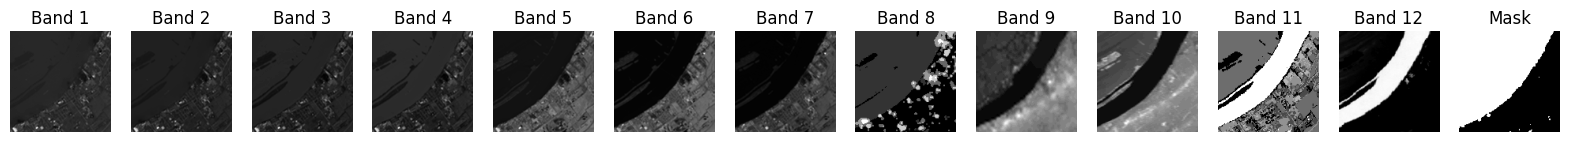

Number of bands: 12


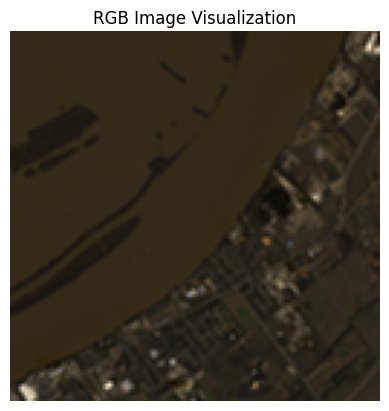

In [ ]:

# Function to display image and mask side by side
def display_image_and_mask(img_path, mask_path):
    img = tiff.imread(img_path) .astype(np.float32)  # Ensure it's float32.open(img_path)
    mask = Image.open(mask_path)

    # Plot the image and the mask side by side
    fig, axes = plt.subplots(1, 13, figsize=(20, 3))

# Iterate over all 12 bands
    for i in range(12):
       bandtodisp = img[:, :, i]
       axes[i].imshow(bandtodisp, cmap='gray')
       axes[i].set_title(f'Band {i+1}')
       axes[i].axis('off')
    axes[12].imshow(mask, cmap='gray')
    axes[12].set_title('Mask')
    axes[12].axis('off')

    plt.show()
def load_and_visualize_multispectral_image(image_path, bands=[4, 3, 2]):
    # Load the image using GDAL
    dataset = gdal.Open(image_path)

    # Check the number of bands
    num_bands = dataset.RasterCount
    print(f"Number of bands: {num_bands}")

    # Select the specified bands (e.g., [4, 3, 2] for RGB)
    selected_bands = []
    for b in bands:
        band = dataset.GetRasterBand(b)
        selected_bands.append(band.ReadAsArray())

    # Stack the bands into an RGB image
    rgb_image = np.dstack(selected_bands)

    # Normalize the image for visualization (optional)
    rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

    # Plot the image
    #plt.figure(figsize=(10, 10))
    plt.figure()
    plt.imshow(rgb_image)
    plt.title('RGB Image Visualization')
    plt.axis('off')
    plt.show()

# Visualize one EACH BAND ON ITS OWN

data_image, label_image = dataset[10]
#label_image.imshow()
display_image_and_mask('/content/drive/MyDrive/datasets/data2/images/12.tif', '/content/drive/MyDrive/datasets/data2/labels/12.png')

# Visualize the first sample
load_and_visualize_multispectral_image('/content/drive/MyDrive/datasets/data2/images/12.tif',bands=[4,3, 2])


MODEL used

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = resnet34(weights=ResNet34_Weights)  # Pre-trained encoder (ResNet34)

        # Modify first conv layer to handle 12-band input
        self.encoder.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Define upsampling layers (decoder)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder (using ResNet34)
        x1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.maxpool(x1)
        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder (upsampling)
        x = self.upconv1(x5)
        x = self.upconv2(x + x4)
        x = self.upconv3(x + x3)
        x = self.upconv4(x + x2)

        x = self.final_conv(x)
        return x

"""class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = resnet34(weights=ResNet34_Weights.DEFAULT)  # Pre-trained encoder (ResNet34)

        # Modify first conv layer to handle 12-band input
        self.encoder.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Define upsampling layers (decoder)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsample from 8x8 to 16x16
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsample from 16x16 to 32x32
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # Upsample from 32x32 to 64x64
        self.upconv4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)    # Upsample from 64x64 to 128x128

        # Adjust channels for skip connections using 1x1 convolutions
        self.conv1x1_1 = nn.Conv2d(256, 256, kernel_size=1)  # To match upconv1
        self.conv1x1_2 = nn.Conv2d(128, 128, kernel_size=1)  # To match upconv2
        self.conv1x1_3 = nn.Conv2d(64, 64, kernel_size=1)   # To match upconv3

        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder (ResNet34)
        print(f"Xinput shape= {x.shape}")
        x1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        print(f"X1 after encoder shape= {x1.shape}")
        x1 = self.encoder.maxpool(x1)  # 64x64
        print(f"X1 after maxpool shape= {x1.shape}")
        x2 = self.encoder.layer1(x1)   # 64x64
        print(f"X2 encoder shape= {x2.shape}")
        x3 = self.encoder.layer2(x2)   # 32x32
        print(f"X3 encoder shape= {x3.shape}")
        x4 = self.encoder.layer3(x3)   # 16x16
        print(f"X4 encoder shape= {x4.shape}")
        x5 = self.encoder.layer4(x4)   # 8x8
        print(f"X5 encoder shape= {x5.shape}")
        # Decoder (upsampling)
        x = self.upconv1(x5)           # 8x8 -> 16x16
        print(f"x upconv 1 dec= {x.shape}")
        x = x + self.conv1x1_1(x4)     # Skip connection from encoder (x4)
        print(f"x conv 1 layer dec= {x.shape}")
        x = self.upconv2(x)            # 16x16 -> 32x32
        print(f"x upconv2 dec= {x.shape}")
        x = x + self.conv1x1_2(x3)     # Skip connection from encoder (x3)

        print(f"x Conv 2 layer dec= {x.shape}")
        x = self.upconv3(x)            # 32x32 -> 64x64
        print(f"x upConv 3 dec= {x.shape}")

        x = x + self.conv1x1_3(x2)     # Skip connection from encoder (x2)

        print(f"x Conv 3 layer dec= {x.shape}")
        x = self.upconv4(x)            # 64x64 -> 128x128


        # Final output layer
        x = self.final_conv(x)         # Output size: [batch_size, num_classes, 128, 128]

        return x
        """
# Instantiate model
from torchvision.models.segmentation import deeplabv3_resnet50,DeepLabV3_ResNet50_Weights
model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
#model = UNet(num_classes=2)
model.backbone.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 92.4MB/s]


In [ ]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)


# Loss function and optimizer
#criterion = nn.CrossEntrolpyLoss()
criterion =nn.BCEWithLogitsLoss()  # Using BCE with logits for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data_image, label_image in train_loader:
        data_image, label_image = data_image.to(device), label_image.to(device)

        optimizer.zero_grad()
        outputs = model(data_image)['out']
        #print(f"predictions shape= {outputs.shape}")
        #print(f"label_image shape= {label_image.shape}")
        # Upsample the output to match the label size (128x128)
        label_image = label_image.squeeze(1).float() #This removes extra dimension
        #outputs_upsampled = torch.nn.functional.interpolate(outputs, size=(128, 128), mode='bilinear', align_corners=False)
        outputs = outputs[:, 0, :, :]  # Shape: [batch_size, height, width]
        #print(f"upsampled shape= {outputs_upsampled.shape}")
        #print(f"upsampled n argmax shape= {outputs.shape}")
        loss = criterion(outputs, label_image)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validate the model after each epoch
    model.eval()
    val_loss = 0.00
    with torch.no_grad():
        for data_image, label_image in valid_loader:
            data_image, label_image = data_image.to(device), label_image.to(device)
            outputs = model(data_image)['out']
            # Upsample the output to match the label size (128x128)
            label_image = label_image.squeeze(1).float()
            #maskin = torch.tensor(label_image, dtype=torch.long)
            outputs = outputs[:, 0, :, :]  # Shape: [batch_size, height, width]
            #outputs_upsample = torch.nn.functional.interpolate(outputs, size=label_image.shape[1:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, label_image)
            val_loss += loss.item()
    print(f"Validation Loss after epoch {epoch+1}: {val_loss/len(valid_loader)}")



Epoch 1/10, Loss: 0.056118639719281944
Validation Loss after epoch 1: 0.7231269888579845
Epoch 2/10, Loss: 0.00877546090182037
Validation Loss after epoch 2: 0.007589573855511844
Epoch 3/10, Loss: 0.008081768031021761
Validation Loss after epoch 3: 0.012137157027609646
Epoch 4/10, Loss: 0.00782246783285612
Validation Loss after epoch 4: 0.0071229805471375585
Epoch 5/10, Loss: 0.007709404716508523
Validation Loss after epoch 5: 0.007002874277532101
Epoch 6/10, Loss: 0.007826499483217635
Validation Loss after epoch 6: 0.006957076140679419
Epoch 7/10, Loss: 0.0076762652850799985
Validation Loss after epoch 7: 0.006874523824080825
Epoch 8/10, Loss: 0.007654962415296224
Validation Loss after epoch 8: 0.0068724347511306405
Epoch 9/10, Loss: 0.00767966132280567
Validation Loss after epoch 9: 0.006965744425542653
Epoch 10/10, Loss: 0.007671490191451965
Validation Loss after epoch 10: 0.006981536163948476


#Evaluation

predict shape b4 function= torch.Size([8, 2, 128, 128])


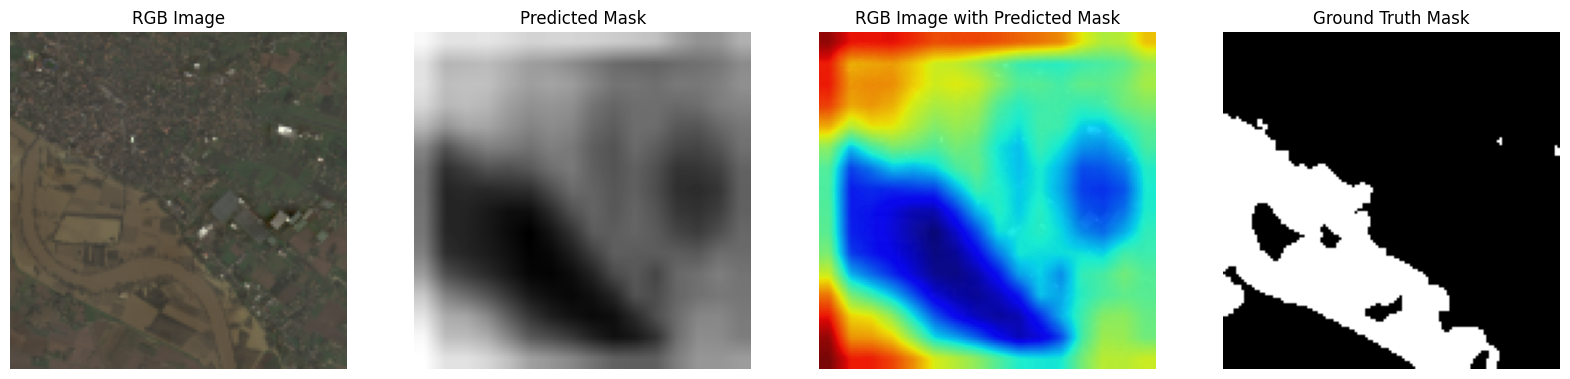

In [ ]:
def visualize_imageovermasks(image_tensor, y_predicted_mask, mask, bands=[4, 3, 2]):
    """
    Visualizes a multispectral image, predicted mask, and actual mask side by side.

    Args:
    - image_tensor (torch.Tensor): The input multispectral image (from dataloader, normalized).
    - y_predicted_mask (torch.Tensor): The predicted mask from the model (shape: [batch, channels, H, W]).
    - mask (torch.Tensor): The ground truth mask from the dataloader.
    - bands (list): List of bands to select for RGB visualization, default is [4, 3, 2].
    """
    # Ensure the image has enough bands for the specified visualization
    assert image_tensor.shape[0] >= max(bands), f"Image does not have enough bands for {bands}"
    num_banmask=1
    # Convert image tensor to numpy for visualization
    image_np = image_tensor.cpu().numpy()
    rgb_image = np.stack([image_np[b - 1] for b in bands], axis=-1)  # Subtract 1 for zero indexing

    # Normalize the image for visualization (bring values between [0, 1])
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Apply sigmoid to get probabilities and convert to binary mask
    y_predicted_mask_sigmoid = torch.sigmoid(y_predicted_mask)  # Apply sigmoid to get probabilities
    #y_predicted_mask_np = (y_predicted_mask_sigmoid > 0.5).int().cpu().numpy()  # Convert to binary mask
    y_predicted_mask_np = y_predicted_mask_sigmoid.cpu().detach().numpy()  # Convert to numpy

    # Get both predicted bands (assume binary segmentation, two channels)
    predicted_band1 = y_predicted_mask_np[0]  # First predicted band
    predicted_band2 = y_predicted_mask_np[1]  # Second predicted band

    # Create a combined mask by averaging the two predicted bands
    combined_mask = (predicted_band1 + predicted_band2)
    # Convert the predicted mask to single-channel (if it's binary segmentation with 2 channels)
    y_predicted_binary = y_predicted_mask_np[num_banmask]  # Use the second channel (class 1) for binary mask visualization

    # Convert the ground truth mask to numpy
    mask_np = mask.squeeze().cpu().numpy()

    # Create an overlay of the predicted mask on the RGB image
    mask_overlay = np.ma.masked_where(y_predicted_binary == 0, y_predicted_binary)  # Assuming 0 is background

    # Plot the RGB image, predicted mask, and RGB image with predicted mask overlay
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Display the RGB image
    axs[0].imshow(rgb_image)
    axs[0].set_title('RGB Image')
    axs[0].axis('off')

    # Display the predicted mask
    image = tensor_to_image(y_predicted_mask[num_banmask], is_prediction=True)

    axs[1].imshow(combined_mask, cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')

    # Display the RGB image with the predicted mask overlaid
    axs[2].imshow(rgb_image)
    axs[2].imshow(combined_mask, cmap='jet', alpha=0.9)  # Alpha for transparency
    axs[2].set_title('RGB Image with Predicted Mask')
    axs[2].axis('off')

    # Display the ground truth mask
    axs[3].imshow(mask_np, cmap='gray')
    axs[3].set_title('Ground Truth Mask')
    axs[3].axis('off')

    plt.show()

def tensor_to_image(tensor, is_prediction=False):
  """Converts a PyTorch tensor to a PIL image.

  Args:
    tensor (torch.Tensor): The input tensor.
      Shape should be (C, H, W) in the range [0, 1].

  Returns:
    PIL.Image: The converted PIL image.
  """
  # Convert to NumPy array
  tensor = tensor.cpu().detach()
  # If it's a prediction, we'll get a single-channel mask.
  if is_prediction:
      if tensor.ndim == 3:  # If the tensor has shape (C, H, W)
          tensor = torch.argmax(tensor, dim=0)  # Take the argmax over the channel dimension

  # Convert the tensor to a NumPy array
  tensor_np = tensor.numpy()

  # Normalize the values to the [0, 255] range
  tensor_np = (tensor_np * 255).astype(np.uint8)

  # If the tensor is a 2D array, convert it directly to an image
  if tensor_np.ndim == 2:  # Shape (H, W) for single-channel grayscale
      return Image.fromarray(tensor_np)

    # If the tensor has 3 channels (RGB), transpose to (H, W, C)
  if tensor_np.shape[0] == 3:  # Shape (C, H, W) for RGB image
      tensor_np = np.transpose(tensor_np, (1, 2, 0))

  return Image.fromarray(tensor_np)

def visualize_multispectral_image_and_masks(image_tensor, y_predicted_mask, mask, bands=[4, 3, 2]):
    """
    Visualizes a multispectral image, predicted mask, and actual mask side by side.

    Args:
    - image_tensor (torch.Tensor): The input multispectral image (from dataloader, normalized).
    - y_predicted_mask (torch.Tensor): The predicted mask from the model.
    - mask (torch.Tensor): The ground truth mask from the dataloader.
    - bands (list): List of bands to select for RGB visualization, default is [4, 3, 2].
    """

    # Move image tensor and masks to device if necessary
    image_tensor = image_tensor.to(device)
    y_predicted_mask = y_predicted_mask.to(device)
    mask = mask.to(device)
    # Ensure the image has enough bands for the specified visualization
    assert image_tensor.shape[0] >= max(bands), f"Image does not have enough bands for {bands}"

    # Select the specified bands for RGB visualization (assuming normalization was done)
    image_np = image_tensor.numpy()
    rgb_image = np.stack([image_np[b - 1] for b in bands], axis=-1)  # Subtract 1 for zero indexing

    # Normalize the image for visualization
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Convert the predicted and actual masks to numpy for visualization
    #y_predicted_mask = torch.argmax(y_predicted_mask, dim=0).numpy()  # Assuming multi-class output
    mask = mask.numpy()

    # Plot the RGB image, predicted mask, and ground truth mask
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Display the RGB image
    axs[3].imshow(rgb_image)
    axs[3].set_title('RGB Image')
    axs[3].axis('off')

    # Display the predicted mask
    print(f"predict shape= {y_predicted_mask.shape}")
    #2 bands
    for i in range(y_predicted_mask.shape[0]):
       image = tensor_to_image(y_predicted_mask[i], is_prediction=True)
       axs[i].imshow(image, cmap='gray')
       axs[i].set_title(f'Band {i+1}')
       axs[i].axis('off')

    # Display the ground truth mask
    print(f"Mask shape= {mask.shape}")
    mask=mask.squeeze()
    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title('Ground Truth Mask')
    axs[2].axis('off')

    plt.show()
data_test, label_test =  next(iter(test_loader))
data_test = data_test.to(device)
label_test = label_test.to(device)
y_predicted_mask =model(data_test)['out']
print(f"predict shape b4 function= {y_predicted_mask.shape}")

#y_predicted_mask = y_predicted_mask.squeeze(1) #This removes extra dimension
#predicted_upsampled = torch.nn.functional.interpolate(y_predicted_mask, size=label_image.shape[1:], mode='bilinear', align_corners=False)

#print(y_predicted_mask.shape)
num=0
visualize_imageovermasks(data_test[num], y_predicted_mask[num], label_test[num])


In [ ]:
from sklearn.metrics import jaccard_score

def dice_coefficient(pred, target):
    smooth = 1e-6  # For numerical stability
    pred = pred.contiguous().view(-1)  # Flatten tensor
    target = target.contiguous().view(-1)  # Flatten tensor
    intersection = (pred * target).sum()  # Intersection of prediction and target
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)  # Dice formula
    return dice.item()

def validate_segmentation_model(model, val_loader, device):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1)  # Ensure ground truth shape is [batch_size, 128, 128]

            outputs = model(images)['out']  # Extract the segmentation output

            # Upsample the output to match the mask size (128x128)
            outputs_upsampled = torch.nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            # Convert outputs to binary predictions (assuming binary classification)
            predictions = torch.sigmoid(outputs_upsampled) > 0.5  # Threshold at 0.5

            # Flatten the tensors for metric calculation
            predictions = predictions.contiguous().view(-1)  # Keep as tensor
            masks = masks.contiguous().view(-1)  # Keep as tensor

            # Calculate Dice coefficient and IoU
            dice = dice_coefficient(predictions, masks)
            iou = jaccard_score(masks.cpu().numpy(), predictions.cpu().numpy(), average='binary')

            dice_scores.append(dice)
            iou_scores.append(iou)

    # Print average metrics
    print(f"Average Dice Coefficient: {np.mean(dice_scores)}")
    print(f"Average IoU: {np.mean(iou_scores)}")

# Call the validation function after training
validate_segmentation_model(model, test_loader, device)


RuntimeError: The size of tensor a (262144) must match the size of tensor b (131072) at non-singleton dimension 0

In [ ]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score


def evaluate_model(model, val_loader):
    model.eval()
    iou_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            outputs = model(images)
            # Upsample the output to match the mask size (128x128) before calculating the metrics
            masks=masks.squeeze()
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            predictions = torch.argmax(outputs, dim=1).cpu().numpy()

            masks = (masks.cpu().numpy() > 0.5).astype(int)

            iou_scores.append(jaccard_score(masks.flatten(), predictions.flatten(), average='binary'))
            precision_scores.append(precision_score(masks.flatten(), predictions.flatten(), average='binary'))
            recall_scores.append(recall_score(masks.flatten(), predictions.flatten(), average='binary'))
            f1_scores.append(f1_score(masks.flatten(), predictions.flatten(), average='binary'))

    print(f"IoU: {np.mean(iou_scores)}")
    print(f"Precision: {np.mean(precision_scores)}")
    print(f"Recall: {np.mean(recall_scores)}")
    print(f"F1-Score: {np.mean(f1_scores)}")
#
evaluate_model(model, test_loader)